In [1]:
import sys
!{sys.executable} -m pip install torch numpy matplotlib scienceplots

import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from matplotlib.animation import PillowWriter
import scienceplots

exist = !which ffmpeg
if not exist:
  !curl https://johnvansickle.com/ffmpeg/releases/ffmpeg-release-amd64-static.tar.xz -o ffmpeg.tar.xz \
     && tar -xf ffmpeg.tar.xz && rm ffmpeg.tar.xz
  ffmdir = !find . -iname ffmpeg-*-static
  path = %env PATH
  path = path + ':' + ffmdir[0]
  %env PATH $path
print('')
!which ffmpeg
print('Done!')

plt.style.use(['science', 'notebook'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39.9M  100 39.9M    0     0  13.8M      0  0:00:02  0:00:02 --:--:-- 13.8M
env: PATH=/home/codespace/.dotnet:/home/codespace/nvm/current/bin:/home/codespace/.php/current/bin:/home/codespace/.python/current/bin:/home/codespace/java/current/bin:/home/codespace/.ruby/current/bin:/home/codespace/.local/bin:/usr/local/python/current/bin:/usr/local/py-utils/bin:/usr/local/jupyter:/usr/local/oryx:/usr/local/go/bin:/go/bin:/usr/local/sdkman/bin:/usr/local/sdkman/candidates/java/current/bin:/usr/local/sdkman/candidates/gradle/current/bin:/usr/local/sdkman/candidates/maven/current/bin:/usr/local/sdkman/candidates/ant/current/bin:/usr/local/rvm/gems/default/bin:/usr/local/rvm/gems/default@global/bin:/usr/local/rvm/rubies/default/bin:/usr/local/share/rbenv/bin:/usr/local/php/current/bin:/opt/conda/bin:/usr/local/nvs:/usr/local/share/nvm/c

Define number of particles and get random positions (between 0 and 1) for each particle

In [2]:
n_particles = 16
r = torch.rand((2,n_particles)).to(device)

In [3]:
n_particles = 16
r = torch.rand((2,n_particles)).to(device)
# Color particles the start on either side
ixr = r[0]>0.5 #right
ixl = r[0]<=0.5 #left

Give IDs to each particle (this will come in handy later)

In [4]:
ids = torch.arange(n_particles)

Plot initial configuration of particles

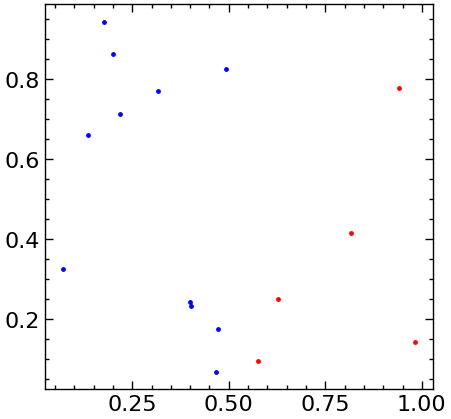

In [5]:
plt.figure(figsize=(5,5))
plt.scatter(r[0][ixr].cpu(),r[1][ixr].cpu(), color='r', s=6)
plt.scatter(r[0][ixl].cpu(),r[1][ixl].cpu(), color='b', s=6)

Obtain the initial velocities in the gas. We'll make the particles starting on the RHS move to the left at 500m/s and on the vice versa.

* **Note**: We're using the assumption that particles in a gas move at approximately 500m/s, thanks google.

In [6]:
v = torch.zeros((2,n_particles)).to(device)
v[0][ixr] = -500
v[0][ixl] = 500

To run this simulation, we need to determine when two particles collide, and what the resulting final velocities will be.

# Part 1: Distance Between all Pairs

* To determine if two particles collide, we need to find the distance between **all pairs** of particles. If the distance is less than 2 times the radius of each particle, they collide. If there are $n$ particles, there are $n(n-1)/2$ pairs (combinatorics). To make this easier, we'll get pairs of particle IDs.

In [7]:
ids_pairs = torch.combinations(ids,2).to(device)
#ids_pairs

We can obtain distances between particles in a similar fashion

* First get the pairs of x-positions of all particles (**NOTE: THIS HAS BEEN UPDATED SINCE THE YOUTUBE VIDEO AND IS MUCH MORE EFFICIENT. THANK YOU TO @swni ON REDDIT FOR THE SUGGESTION**)

In [8]:
x_pairs = torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T
x_pairs

tensor([[0.4672, 0.8156],
        [0.4672, 0.3177],
        [0.4672, 0.5745],
        [0.4672, 0.2178],
        [0.4672, 0.4017],
        [0.4672, 0.4713],
        [0.4672, 0.1355],
        [0.4672, 0.9416],
        [0.4672, 0.6288],
        [0.4672, 0.0704],
        [0.4672, 0.1782],
        [0.4672, 0.4002],
        [0.4672, 0.9826],
        [0.4672, 0.2009],
        [0.4672, 0.4934],
        [0.8156, 0.3177],
        [0.8156, 0.5745],
        [0.8156, 0.2178],
        [0.8156, 0.4017],
        [0.8156, 0.4713],
        [0.8156, 0.1355],
        [0.8156, 0.9416],
        [0.8156, 0.6288],
        [0.8156, 0.0704],
        [0.8156, 0.1782],
        [0.8156, 0.4002],
        [0.8156, 0.9826],
        [0.8156, 0.2009],
        [0.8156, 0.4934],
        [0.3177, 0.5745],
        [0.3177, 0.2178],
        [0.3177, 0.4017],
        [0.3177, 0.4713],
        [0.3177, 0.1355],
        [0.3177, 0.9416],
        [0.3177, 0.6288],
        [0.3177, 0.0704],
        [0.3177, 0.1782],
        [0.3

* Then take the difference to get $\Delta x_{ij}$ of all pairs

In [9]:
dx_pairs = torch.diff(x_pairs, axis=1).ravel()
dx_pairs

tensor([ 0.3484, -0.1495,  0.1073, -0.2493, -0.0654,  0.0041, -0.3317,  0.4744,
         0.1616, -0.3968, -0.2890, -0.0670,  0.5155, -0.2663,  0.0263, -0.4979,
        -0.2411, -0.5978, -0.4139, -0.3443, -0.6802,  0.1260, -0.1868, -0.7453,
        -0.6374, -0.4154,  0.1670, -0.6147, -0.3222,  0.2568, -0.0999,  0.0841,
         0.1536, -0.1822,  0.6239,  0.3111, -0.2473, -0.1395,  0.0825,  0.6649,
        -0.1168,  0.1757, -0.3566, -0.1727, -0.1032, -0.4390,  0.3671,  0.0543,
        -0.5041, -0.3963, -0.1743,  0.4082, -0.3736, -0.0810,  0.1839,  0.2535,
        -0.0824,  0.7238,  0.4109, -0.1475, -0.0397,  0.1824,  0.7648, -0.0170,
         0.2756,  0.0696, -0.2663,  0.5399,  0.2270, -0.3314, -0.2236, -0.0015,
         0.5809, -0.2009,  0.0917, -0.3359,  0.4703,  0.1575, -0.4010, -0.2931,
        -0.0711,  0.5113, -0.2704,  0.0221,  0.8062,  0.4933, -0.0651,  0.0427,
         0.2648,  0.8472,  0.0654,  0.3580, -0.3128, -0.8713, -0.7634, -0.5414,
         0.0410, -0.7407, -0.4482, -0.55

The total distance is just $d_{ij}= \sqrt{\Delta x_{ij}^2 + \Delta y_{ij}^2}$. Since there are $n(n-1)/2$ pairs, there will be $n(n-1)/2$ different values of $d_{ij}$.

In [10]:
x_pairs = torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T
y_pairs = torch.stack([r[1][ids_pairs[:,0]], r[1][ids_pairs[:,1]]]).T
dx_pairs = torch.diff(x_pairs, axis=1).ravel()
dy_pairs = torch.diff(y_pairs, axis=1).ravel()
d_pairs = torch.sqrt(dx_pairs**2 + dy_pairs**2)
d_pairs

tensor([0.4920, 0.7192, 0.1108, 0.6910, 0.1780, 0.1058, 0.6797, 0.8532, 0.2427,
        0.4724, 0.9226, 0.1863, 0.5206, 0.8380, 0.7572, 0.6121, 0.4006, 0.6675,
        0.4521, 0.4207, 0.7232, 0.3830, 0.2501, 0.7508, 0.8282, 0.4502, 0.3210,
        0.7602, 0.5209, 0.7230, 0.1160, 0.5445, 0.6172, 0.2130, 0.6239, 0.6080,
        0.5111, 0.2220, 0.5361, 0.9162, 0.1481, 0.1836, 0.7125, 0.2210, 0.1294,
        0.7160, 0.7741, 0.1628, 0.5536, 0.9366, 0.2275, 0.4107, 0.8531, 0.7337,
        0.5130, 0.5954, 0.0970, 0.7267, 0.6193, 0.4153, 0.2351, 0.5047, 0.9546,
        0.1511, 0.2976, 0.0917, 0.5038, 0.7661, 0.2276, 0.3436, 0.7450, 0.0085,
        0.5882, 0.6604, 0.5983, 0.5920, 0.7651, 0.1746, 0.4283, 0.8244, 0.0985,
        0.5123, 0.7401, 0.6515, 0.8144, 0.6428, 0.3432, 0.2862, 0.4960, 0.9940,
        0.2117, 0.3936, 0.6137, 0.9819, 0.7815, 0.7613, 0.6372, 0.7456, 0.4507,
        0.5635, 0.8283, 0.2287, 0.3699, 0.7480, 0.5914, 0.6293, 0.3400, 0.9305,
        0.5540, 0.6554, 0.7366, 1.1366, 

# Part 2: Velocities of a Collision

So at each iteration of the simulation, we will evaluate `d_pairs`, and if any of the distances between particles is less than $2r$, then a collision occurs. What is the final velocity of each of the two spheres? In an elastic collision (conservation of energy + momentum + angular momentum), one can show

$$\vec{v}_1^{\text{new}} = \vec{v}_1 - \frac{(\vec{v}_1 - \vec{v}_2) \cdot (\vec{r}_1 - \vec{r}_2)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_1 - \vec{r}_2)$$
$$\vec{v}_2^{\text{new}} = \vec{v}_2 - \frac{(\vec{v}_2 - \vec{v}_1) \cdot (\vec{r}_2 - \vec{r}_1)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_2 - \vec{r}_1)$$

In [11]:
radius = 0.06
ids_pairs_collide = ids_pairs[d_pairs < 2*radius]
ids_pairs_collide

tensor([[ 0,  3],
        [ 0,  6],
        [ 2,  4],
        [ 4,  7],
        [ 5,  6],
        [ 5, 12],
        [ 6, 12],
        [11, 14]])

We will call all the particles in the left column "1" and the right column "2"

In [12]:
v1 = v[:,ids_pairs_collide[:,0]]
v2 = v[:,ids_pairs_collide[:,1]]
r1 = r[:,ids_pairs_collide[:,0]]
r2 = r[:,ids_pairs_collide[:,1]]

Then we can compute the new velocity:

In [13]:
v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)

# Part 3: Functions to Run the Simulation

Here we define some functions that will help make running the simulation easier.

In [14]:
def get_deltad2_pairs(r, ids_pairs):
    dx = torch.diff(torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T).squeeze()
    dy = torch.diff(torch.stack([r[1][ids_pairs[:,0]], r[1][ids_pairs[:,1]]]).T).squeeze()
    return dx**2 + dy**2

def compute_new_v(v1, v2, r1, r2):
    v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
    v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)
    return v1new, v2new

def motion(r, v, id_pairs, ts, dt, d_cutoff):
    rs = torch.zeros((ts, r.shape[0], r.shape[1])).to(device)
    vs = torch.zeros((ts, v.shape[0], v.shape[1])).to(device)
    # Initial State
    rs[0] = r
    vs[0] = v
    for i in range(1,ts):
        ic = id_pairs[get_deltad2_pairs(r, ids_pairs) < d_cutoff**2]
        v[:,ic[:,0]], v[:,ic[:,1]] = compute_new_v(v[:,ic[:,0]], v[:,ic[:,1]], r[:,ic[:,0]], r[:,ic[:,1]])
        
        v[0,r[0]>1] = -torch.abs(v[0,r[0]>1])
        v[0,r[0]<0] = torch.abs(v[0,r[0]<0])
        v[1,r[1]>1] = -torch.abs(v[1,r[1]>1])
        v[1,r[1]<0] = torch.abs(v[1,r[1]<0])
        
        r = r + v*dt
        rs[i] = r
        vs[i] = v
    return rs, vs

Set the radius and find the position of all particles as a function of time (3D array `rs` where each axis is $(t,x,y)$).

In [15]:
radius = 0.03
rs, vs = motion(r, v, ids_pairs, ts=1000, dt=0.000008, d_cutoff=2*radius)

Plot red and blue circles, making sure each is the correct size.

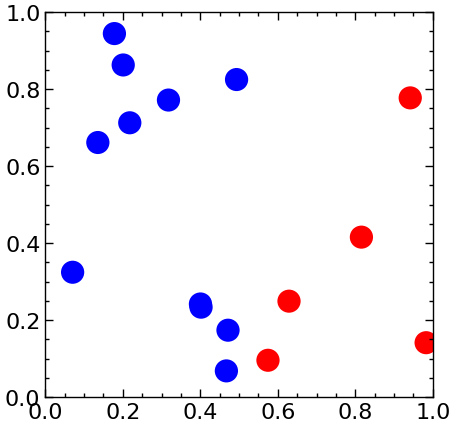

In [16]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
xred, yred = rs[0][0][ixr], rs[0][1][ixr]
xblue, yblue = rs[0][0][ixl],rs[0][1][ixl]
circles_red = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xred,yred)]
circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xblue,yblue)]
cred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
ax.add_collection(cred)
ax.add_collection(cblue)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

Make initial animation of the simulation

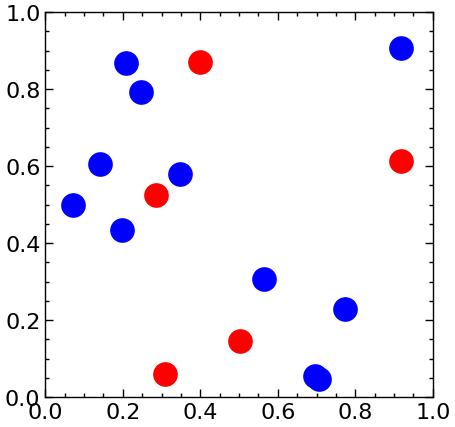

In [17]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.clear()
vmin = 0
vmax = 1
ax.set_xlim(0,1)
ax.set_ylim(0,1)
markersize = 2 * radius * ax.get_window_extent().width  / (vmax-vmin) * 72./fig.dpi
red, = ax.plot([], [], 'o', color='red', markersize=markersize)
blue, = ax.plot([], [], 'o', color='blue', markersize=markersize)

def animate(i):
    xred, yred = rs[i][0][ixr].cpu(), rs[i][1][ixr].cpu()
    xblue, yblue = rs[i][0][ixl].cpu(),rs[i][1][ixl].cpu()
    red.set_data(xred, yred)
    blue.set_data(xblue, yblue)
    return red, blue

writer = animation.FFMpegWriter(fps=30)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50, blit=True)
ani.save('ani3.mp4',writer=writer,dpi=100)

Now that we're sure that it works, lets make a simulation containing many more particles

In [ ]:
n_particles = 5000
r = torch.rand((2,n_particles)).to(device)
ixr = r[0]>0.5 
ixl = r[0]<=0.5 
ids = torch.arange(n_particles)
ids_pairs = torch.combinations(ids,2).to(device)
v = torch.zeros((2,n_particles)).to(device)
v[0][ixr] = -500
v[0][ixl] = 500
radius = 0.0005
rs, vs = motion(r, v, ids_pairs, ts=1000, dt=0.000008, d_cutoff=2*radius)

Let's look at the final velocity distribution of the particles and compare it to Maxwell-Boltzmann in 2 Dimensions:

* $kT = KE_{avg} = \frac{1}{2}m\bar{v^2} \implies \boxed{\frac{m}{kT} = \frac{2}{\bar{v^2}}}$
* $\boxed{f(v) = \frac{m}{kT} v \exp\left(-\frac{m}{kT}\frac{v^2}{2} \right)}$

In [ ]:
v = np.linspace(0, 2000, 1000)
a = 2/500**2
fv = a*v*np.exp(-a*v**2 / 2)

Plot the final histogram next to this curve:

In [ ]:
bins = np.linspace(0,1500,50)
plt.figure()
plt.hist(torch.sqrt(torch.sum(vs[-1]**2, axis=0)).cpu(), bins=bins, density=True)
plt.plot(v,fv)
plt.xlabel('Velocity [m/s]')
plt.ylabel('# Particles')

Finally, we can make an animation of the particles moving around and the histogram at the same time

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
axes[0].clear()
vmin = 0
vmax = 1
axes[0].set_xlim(0,1)
axes[0].set_ylim(0,1)
markersize = 2 * radius * axes[0].get_window_extent().width  / (vmax-vmin) * 72./fig.dpi
red, = axes[0].plot([], [], 'o', color='red', markersize=markersize)
blue, = axes[0].plot([], [], 'o', color='blue', markersize=markersize)
n, bins, patches = axes[1].hist(torch.sqrt(torch.sum(vs[0]**2, axis=0)).cpu(), bins=bins, density=True)
axes[1].plot(v,fv)
axes[1].set_ylim(top=0.003)

def animate(i):
    xred, yred = rs[i][0][ixr].cpu(), rs[i][1][ixr].cpu()
    xblue, yblue = rs[i][0][ixl].cpu(),rs[i][1][ixl].cpu()
    red.set_data(xred, yred)
    blue.set_data(xblue, yblue)
    hist, _ = np.histogram(torch.sqrt(torch.sum(vs[i]**2, axis=0)).cpu(), bins=bins, density=True)
    for i, patch in enumerate(patches):
        patch.set_height(hist[i])
    return red, blue

writer = animation.FFMpegWriter(fps=30)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50, blit=True)
ani.save('ani_gpu_10000.mp4',writer=writer,dpi=100)